In [1]:
import os
import pathlib
import pickle
import matplotlib.pyplot as plt
import numpy as np
from models import *
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
from python_speech_features import mfcc
import librosa.display
import librosa as lr
from sklearn.metrics import confusion_matrix
import itertools

sns.set_context("paper")

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from hyperparams import _DATA_DIR_, _BINARIES_DIR_, _UNKNOWN_CLASS_, _SILENCE_CLASS_, _MODELS_DIR_, _TASKS_
from input_pipeline import *
from metrics import *
from custom_layers import MFCC, LogMelSpectrogram, Spectrogram
from utils import *

2021-08-27 18:41:26.860418: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


# Input Pipeline
The most challenging part of the project was to build an efficient input pipeline.
(explain...)

## Getting the file names for each split

In [2]:
_SMOKE_SIZE_ = -1
current_task = _TASKS_[0]
print(current_task)
core_kws, aux_kws, output_classes = get_kws(_DATA_DIR_, current_task)
print("Core keywords: ", core_kws)
print()
print("Auxiliary keywords: ", aux_kws)
print()
print("Output Classes: ", output_classes)
# if the binaries for the splits are not yet generated, generate them; otherwise just load them.
if len(os.listdir(_BINARIES_DIR_/current_task)) == 0:
    #Get train, validation and test data from the splits provided in the data directory
    make_and_save_original_splits(current_task, return_canonical_test_set=False)

X_train, y_train, X_valid, y_valid, X_test, y_test = load_original_splits(current_task, smoke_size=_SMOKE_SIZE_)



print(f"Samples in Training Set: {len(X_train)}")
print(f"Samples in Test Set: {len(X_test)}")
print(f"Samples in Validation Set: {len(X_valid)}")

10kws+U+S
Core keywords:  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

Auxiliary keywords:  ['dog', 'marvin', 'one', 'bed', 'house', 'three', 'bird', 'backward', 'eight', 'cat', 'sheila', 'follow', 'two', 'wow', 'visual', 'forward', 'seven', 'six', 'happy', 'nine', 'learn', 'four', 'five', 'zero', 'tree']

Output Classes:  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'filler', 'silence']
Samples in Training Set: 36921
Samples in Test Set: 4888
Samples in Validation Set: 4443


In [3]:
# ensure they are disjoint sets
print(set(X_train).intersection(set(X_valid)))
print(set(X_valid).intersection(set(X_test)))

{'silence'}
{'silence'}


In [4]:
#dummy datasets
indexes_train = np.random.choice(len(X_train),30)
X_train = X_train[indexes_train]
y_train = y_train[indexes_train]
X_valid = X_valid[:10]
y_valid = y_valid[:10]
X_test = X_test[:20]
y_test = y_test[:20]

In [6]:
[output_classes[i] for i in y_train]

['go',
 'yes',
 'up',
 'stop',
 'off',
 'down',
 'yes',
 'down',
 'no',
 'on',
 'filler',
 'stop',
 'up',
 'left',
 'down',
 'stop',
 'left',
 'yes',
 'left',
 'filler',
 'down',
 'go',
 'go',
 'silence',
 'right',
 'go',
 'up',
 'no',
 'down',
 'stop']

In [7]:
train_dataset = create_dataset(X_train, y_train, batch_size=1, is_training=True, cache_file="dummy_train")
valid_dataset = create_dataset(X_valid, y_valid, batch_size=1,cache_file="dummy_valid")
test_dataset = create_dataset(X_test, y_test, batch_size=1, is_test=True, cache_file="dummy_test")

2021-08-27 18:41:56.903454: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-27 18:41:56.968966: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-27 18:41:56.969538: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.7845GHz coreCount: 10 deviceMemorySize: 5.93GiB deviceMemoryBandwidth: 178.99GiB/s
2021-08-27 18:41:56.969606: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-27 18:41:56.972119: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-27 18:41:56.972183: I tensorflow/stream_executor/platf

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


## Generating noise

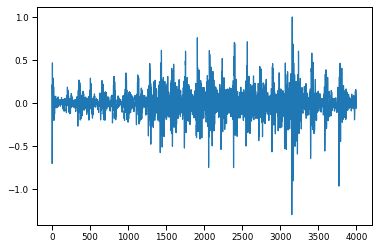

In [6]:
w2 = randomly_crop_wave(w, 4000)
plt.plot(w2)
plt.show()

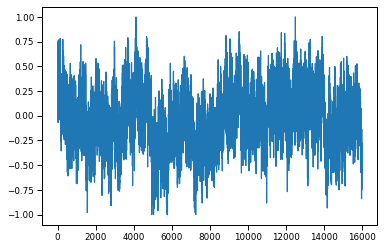

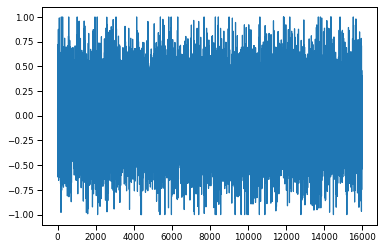

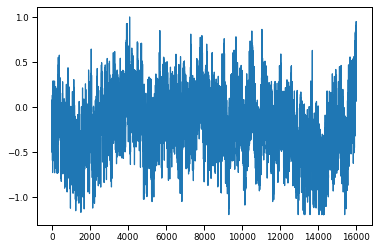

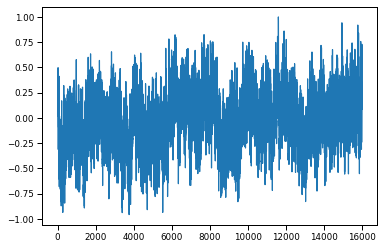

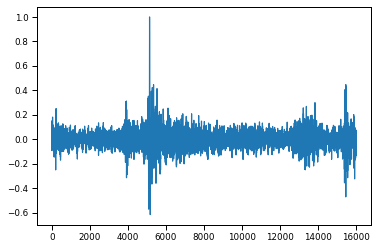

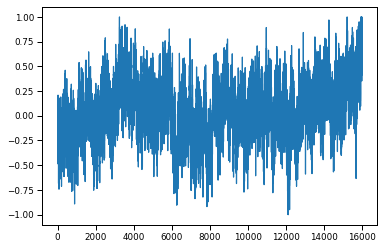

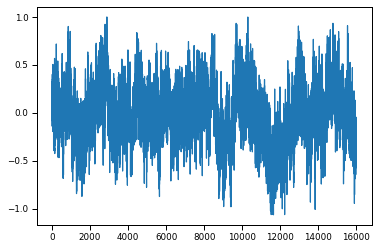

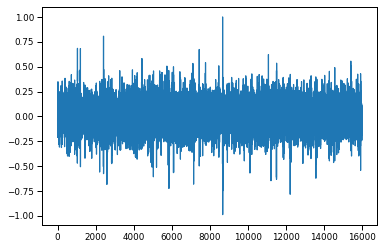

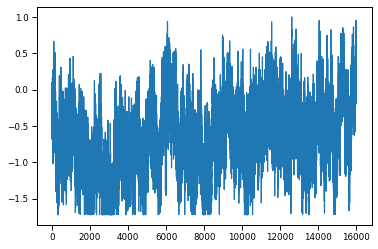

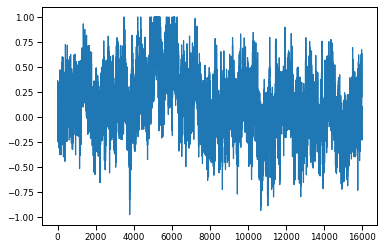

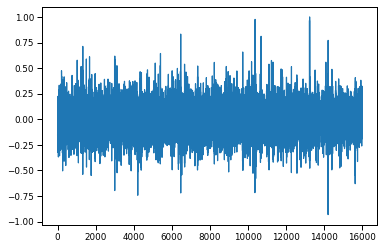

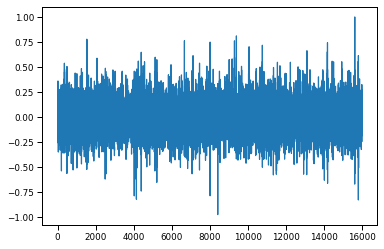

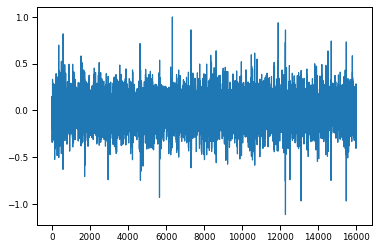

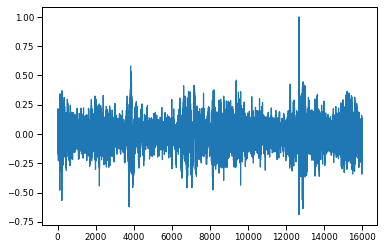

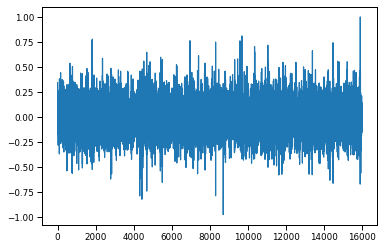

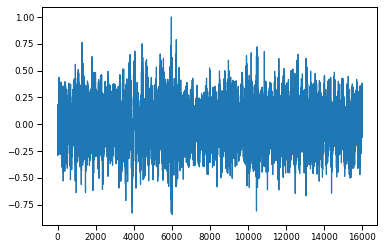

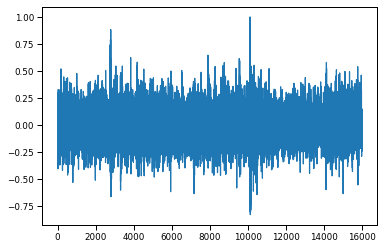

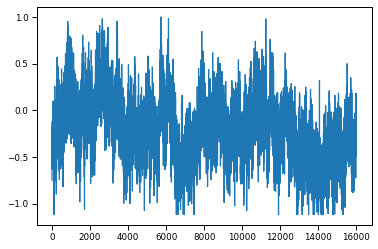

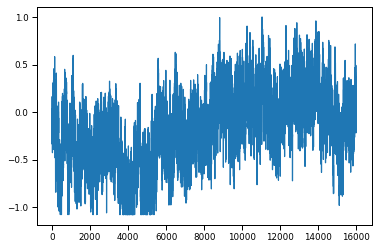

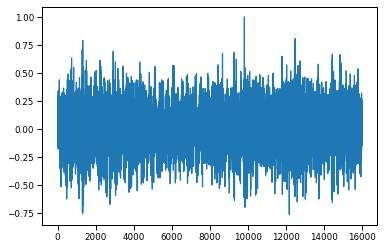

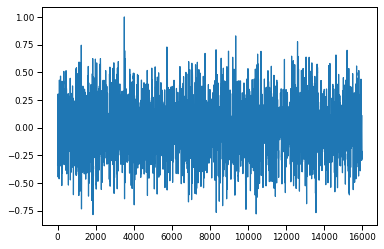

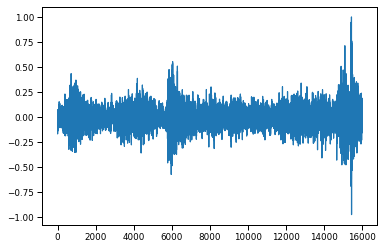

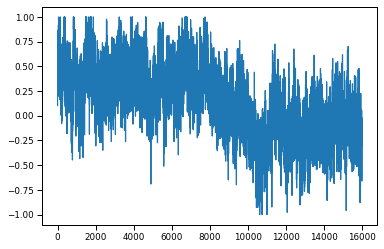

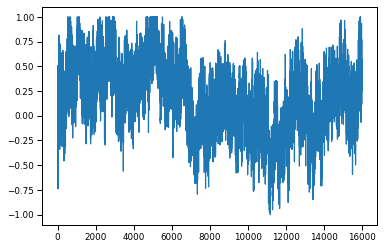

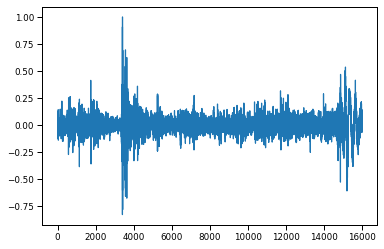

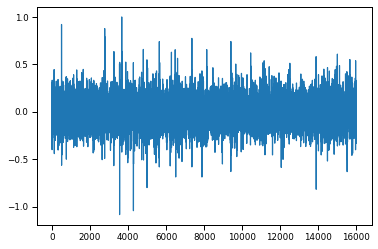

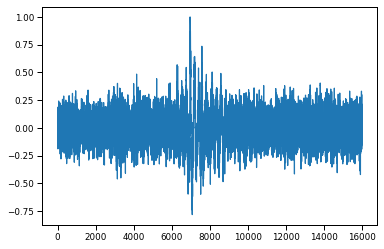

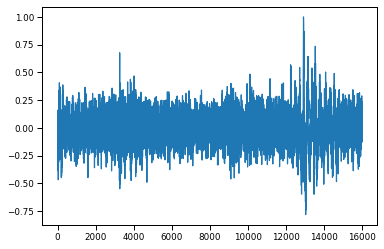

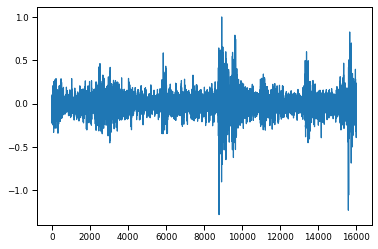

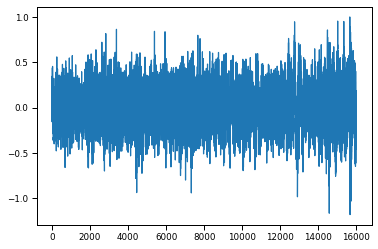

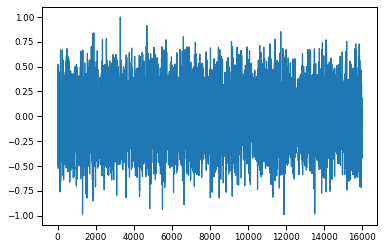

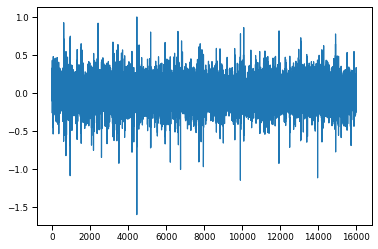

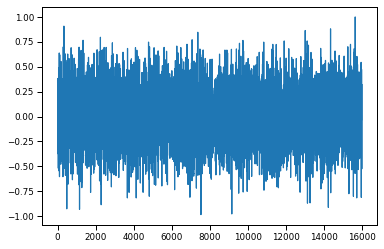

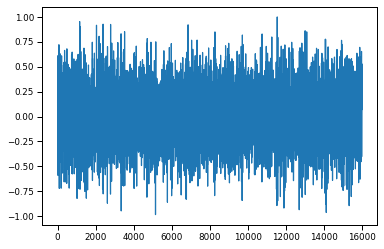

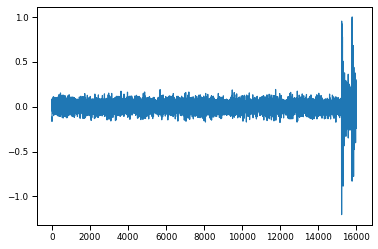

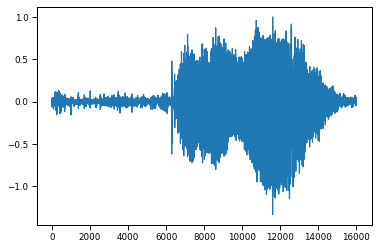

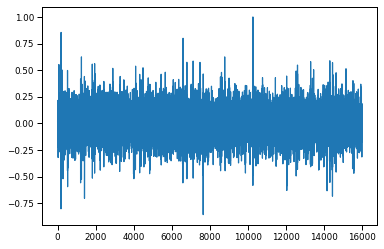

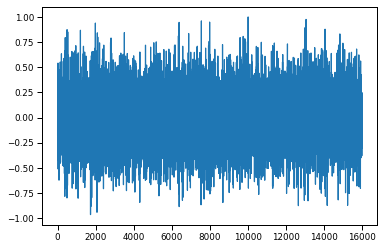

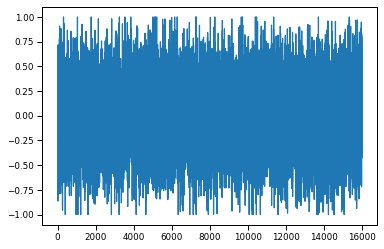

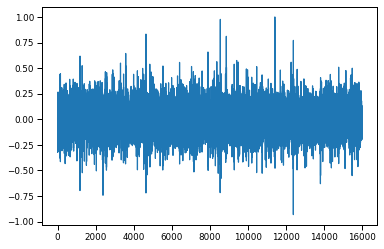

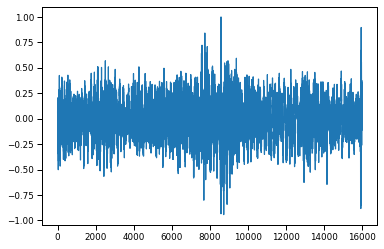

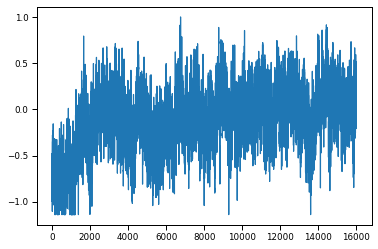

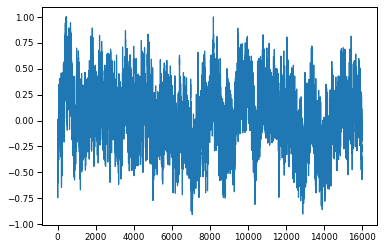

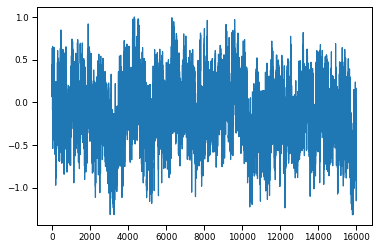

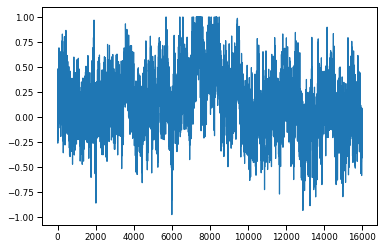

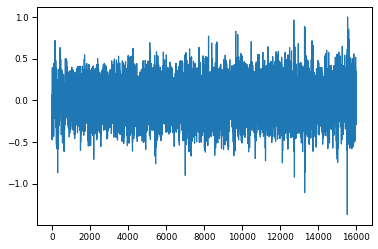

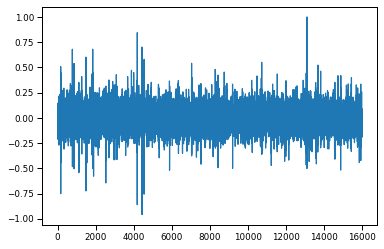

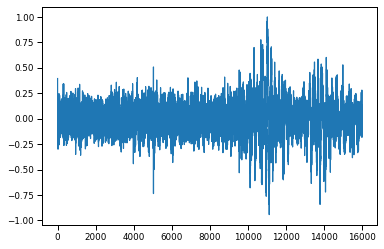

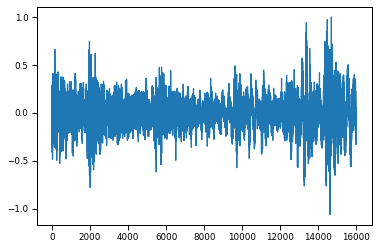

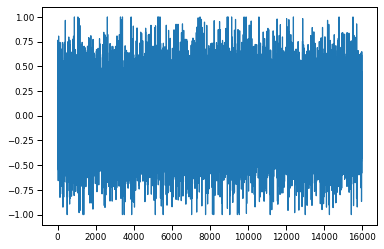

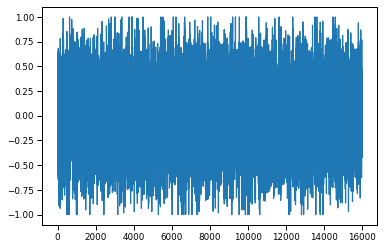

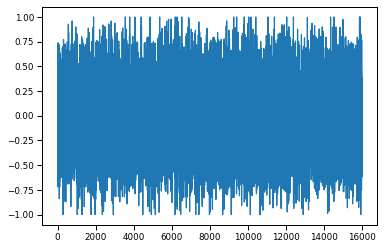

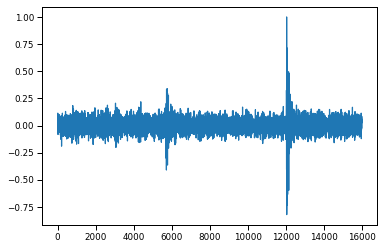

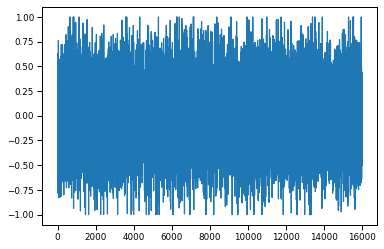

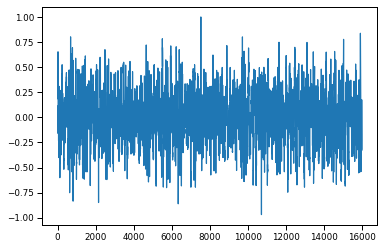

In [23]:
for i in train_dataset.take(1000):
    if i[1]==11:
        plt.plot(i[0][0]) 
        display.display(display.Audio(i[0][0], rate=16000))
        plt.show()

In [56]:
get_noise_samples_names()

<tf.Tensor: shape=(6,), dtype=string, numpy=
array([b'data/speech_commands_v0.02/_background_noise_/exercise_bike.wav',
       b'data/speech_commands_v0.02/_background_noise_/pink_noise.wav',
       b'data/speech_commands_v0.02/_background_noise_/doing_the_dishes.wav',
       b'data/speech_commands_v0.02/_background_noise_/white_noise.wav',
       b'data/speech_commands_v0.02/_background_noise_/running_tap.wav',
       b'data/speech_commands_v0.02/_background_noise_/dude_miaowing.wav'],
      dtype=object)>

In [99]:
choice = tf.cast(tf.random.uniform([],0,len(get_noise_samples_names())), dtype=tf.int32)
noise_file = tf.gather(get_noise_samples_names(), choice)
print(choice)
print(noise_file)

tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(b'data/speech_commands_v0.02/_background_noise_/white_noise.wav', shape=(), dtype=string)


## See data augmentation

2021-08-24 18:57:52.281136: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-24 18:57:52.304745: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2699905000 Hz


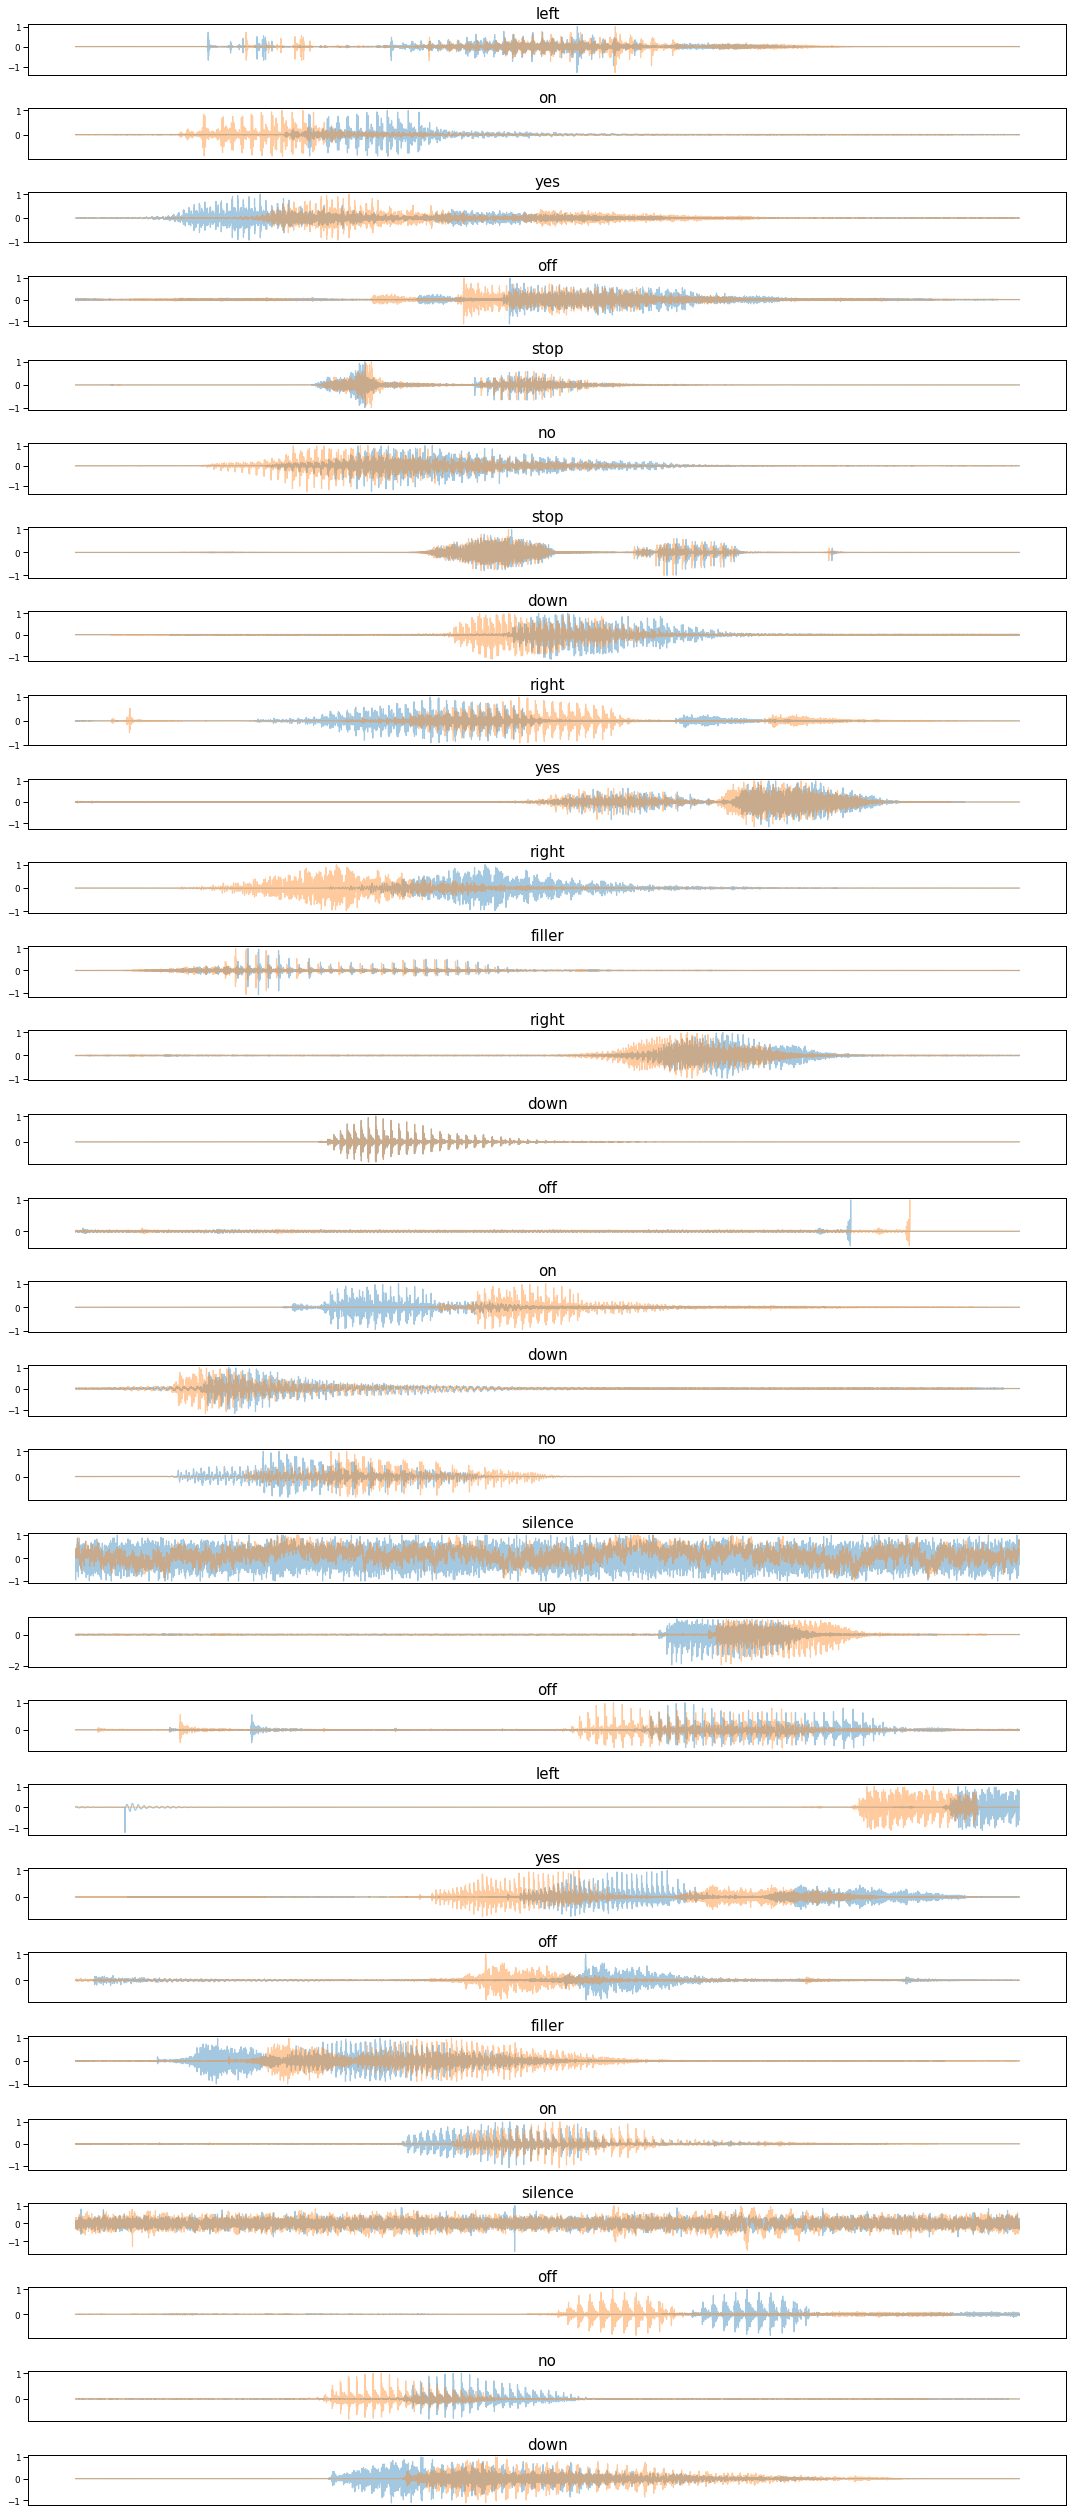

In [7]:
count = 1
plt.figure(figsize=(15,35))

n = 30

for s in train_dataset.take(2*n):
    if count<=n:
#         plt.subplot(20,2,2*count+1)
        plt.subplot(n,1,count)
        w = s[0][0]
        lab = s[1][0]
        plt.plot(w, alpha=0.4, label="it1")
        plt.title(output_classes[lab], fontsize=15)
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
    else:
#         plt.subplot(20,2,(count-9)*2)
        plt.subplot(n,1,count-n)
        w = s[0][0]
        lab = s[1][0]
        plt.plot(w, alpha=0.4, label="it2")
#         plt.legend(fontsize=16)
#         plt.title(output_classes[lab])
    count+=1
# plt.suptitle("Training set samples in different iterations")
plt.tight_layout()

plt.show()

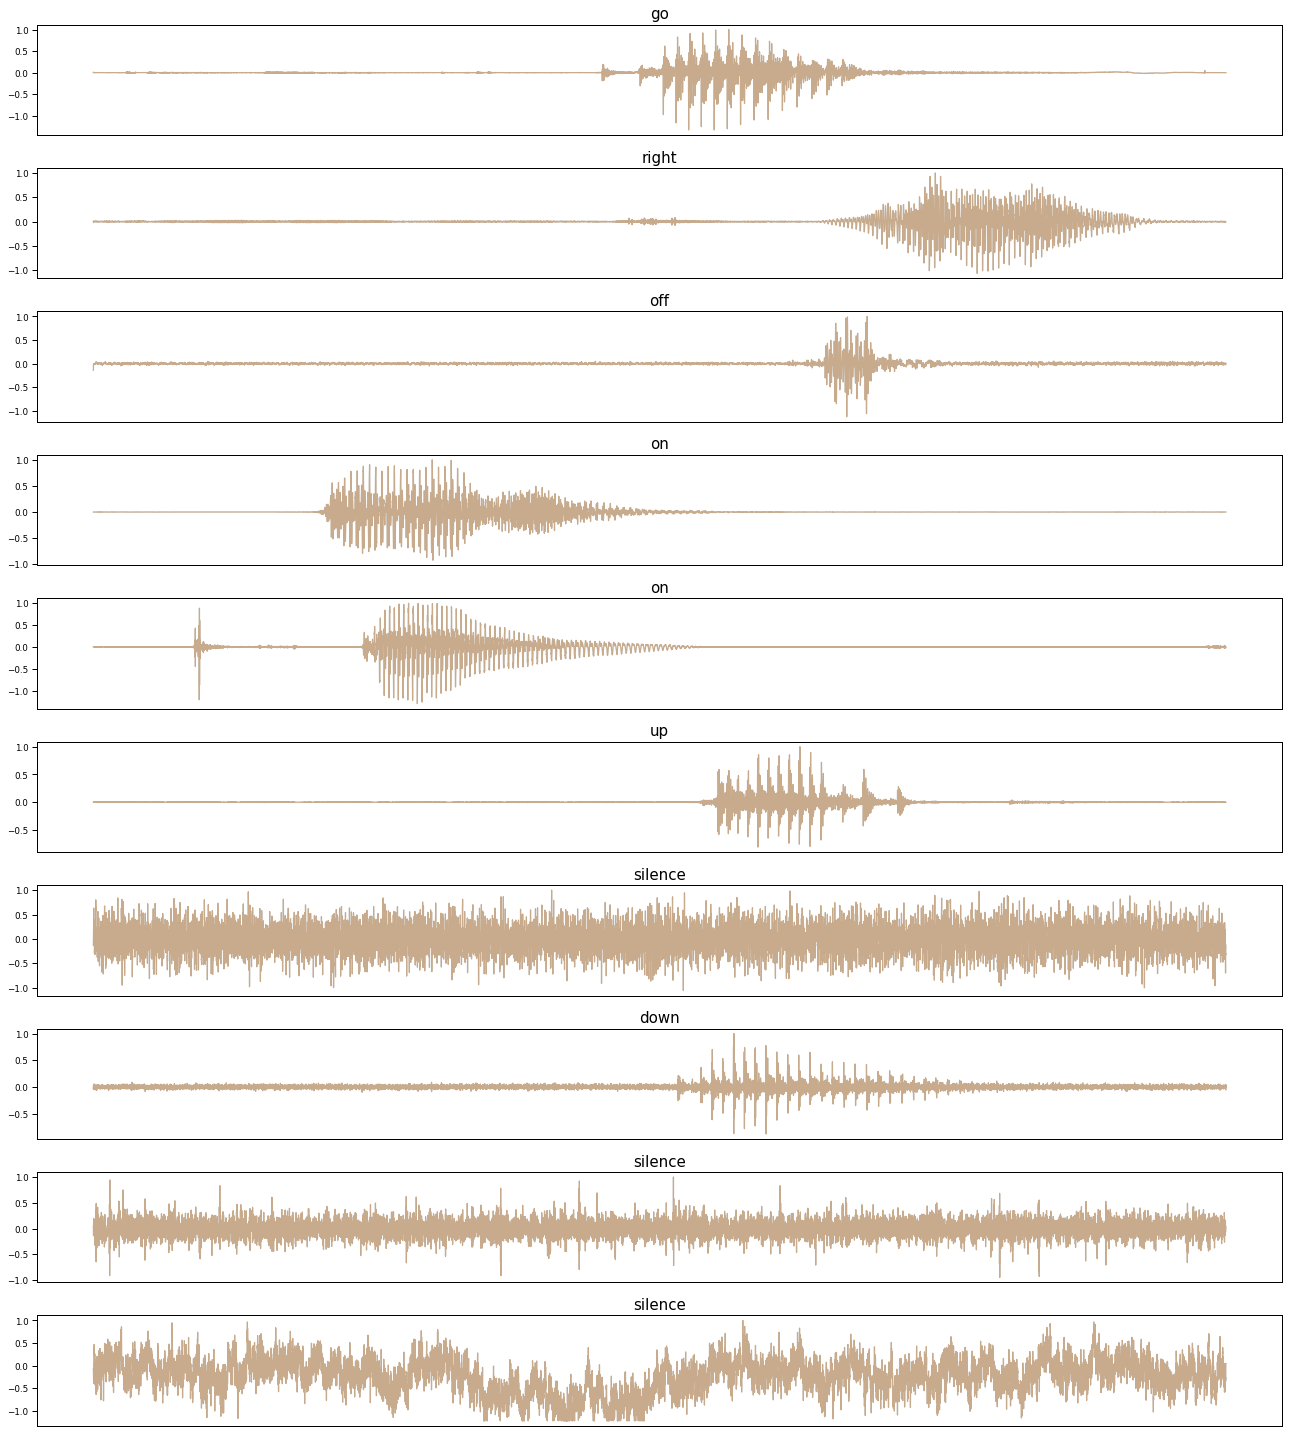

In [8]:
count = 1
plt.figure(figsize=(18,20))
for s in valid_dataset.take(20):
    if count<=10:
#         plt.subplot(20,2,2*count+1)
        plt.subplot(10,1,count)
        w = s[0][0]
        lab = s[1][0]
        plt.plot(w, alpha=0.4, label="it1")
        plt.title(output_classes[lab], fontsize=15)
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
    else:
#         plt.subplot(20,2,(count-9)*2)
        plt.subplot(10,1,count-10)
        w = s[0][0]
        lab = s[1][0]
        plt.plot(w, alpha=0.4, label="it2")
#         plt.legend(fontsize=16)
#         plt.title(output_classes[lab])
    count+=1
plt.tight_layout()

plt.show()

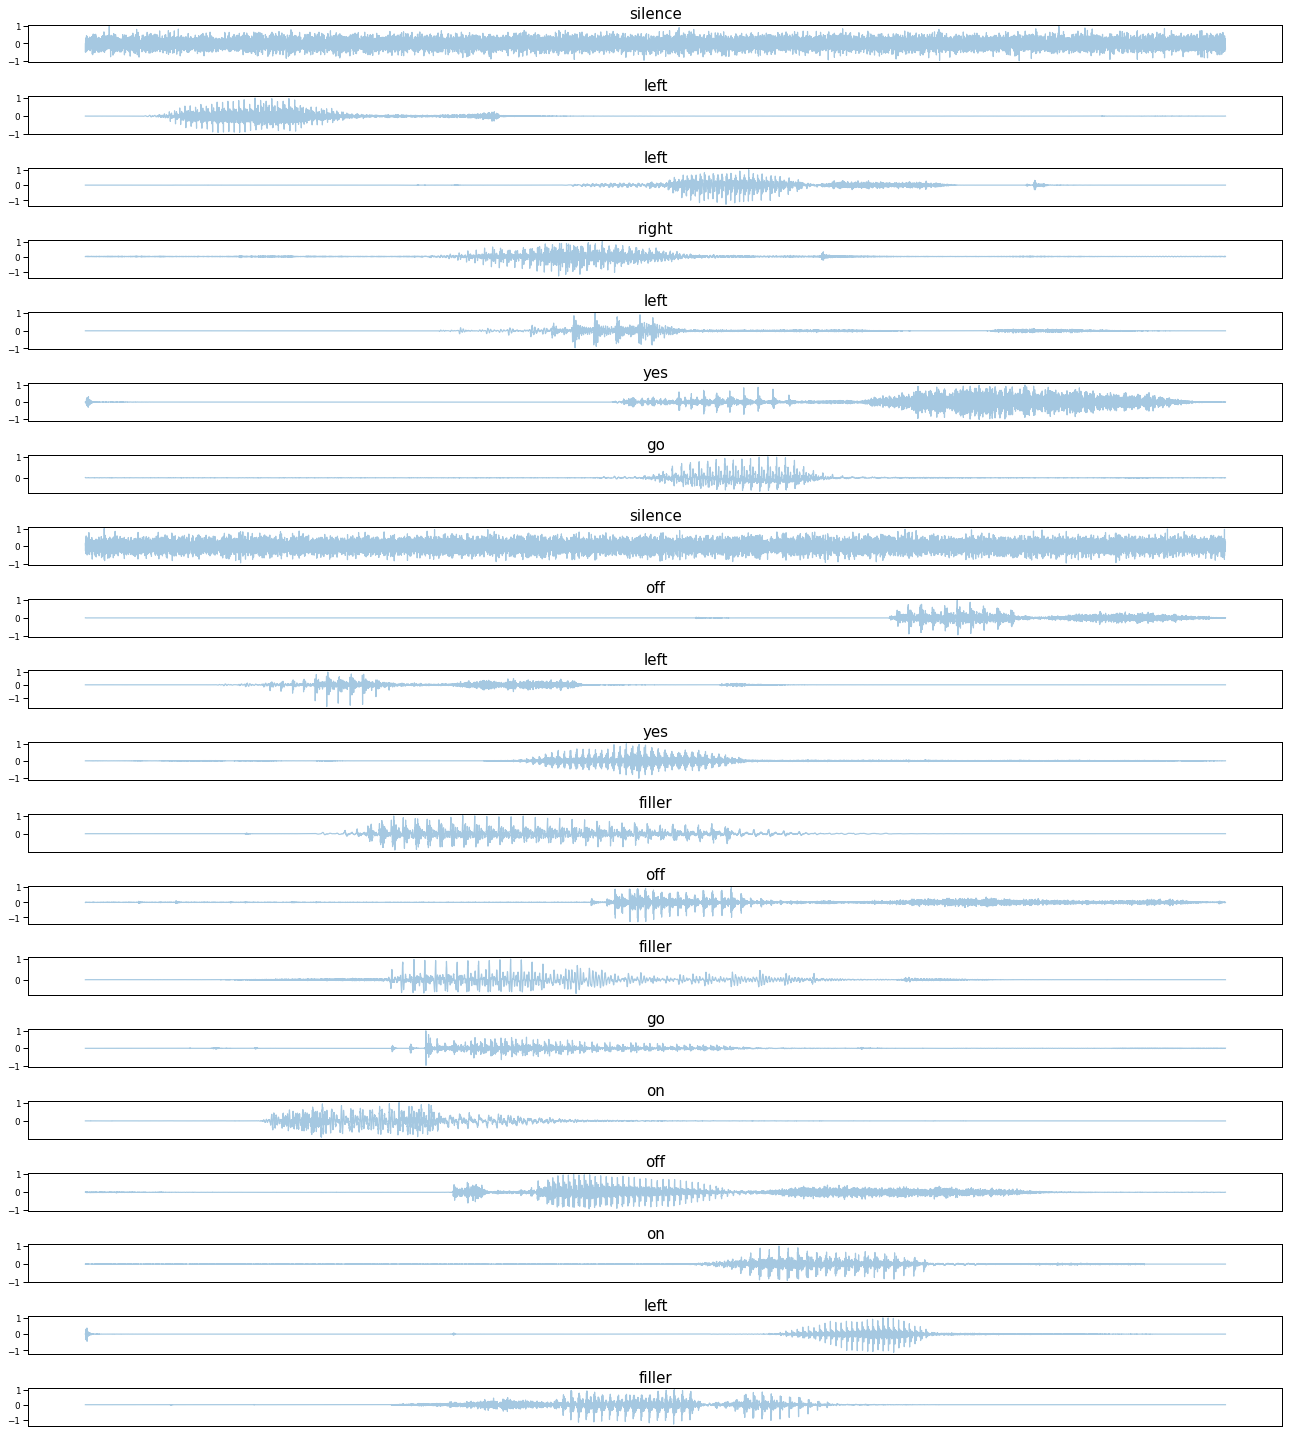

In [9]:
count = 1
plt.figure(figsize=(18,20))
for s in test_dataset.take(20):
    if count<=20:
#         plt.subplot(20,2,2*count+1)
        plt.subplot(20,1,count)
        w = s[0]
        lab = s[1]
        plt.plot(w, alpha=0.4, label="it1")
        plt.title(output_classes[lab], fontsize=15)
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
#         plt.legend(fontsize=16)
#         plt.title(output_classes[lab])
    count+=1
plt.tight_layout()

plt.show()

## Noise augmentation

In [42]:
aug_layer = RandomNoiseAugment()

In [43]:
ws = []
labs = []
for i in train_dataset.take(10):
    ws.append(i[0])
    labs.append(i[1])
ws = tf.concat(ws, axis=0)
labs = tf.concat(labs, axis=0)

2021-08-27 18:18:38.538033: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


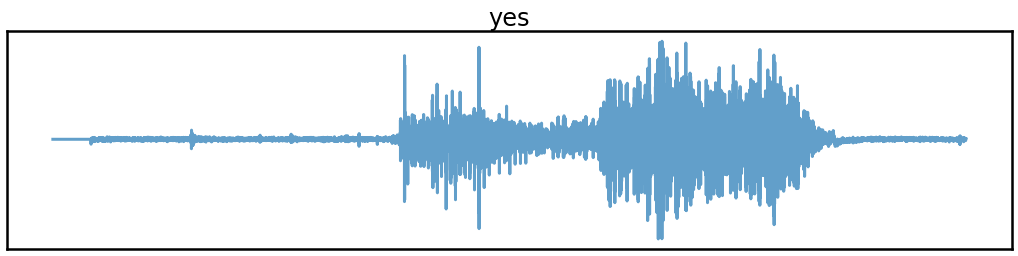

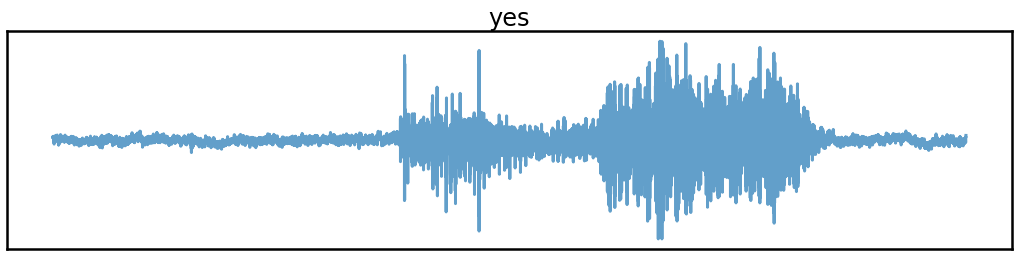

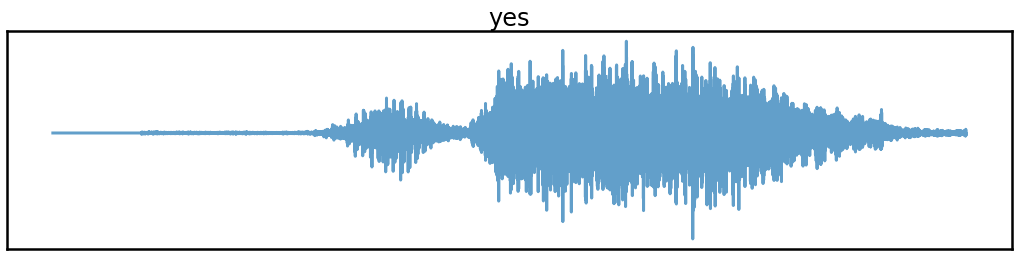

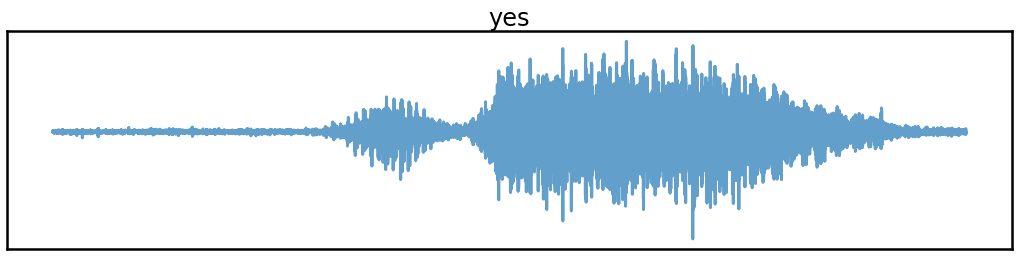

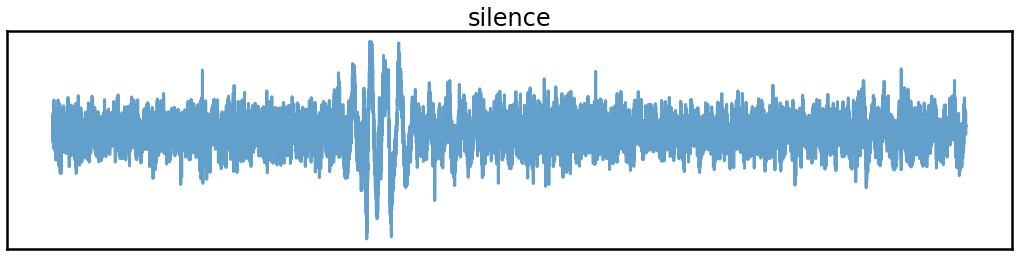

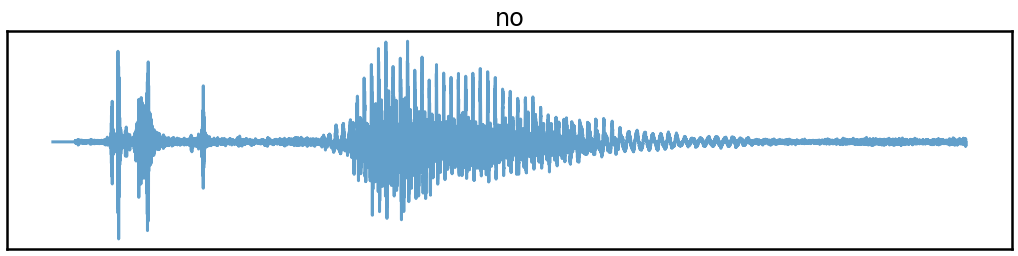

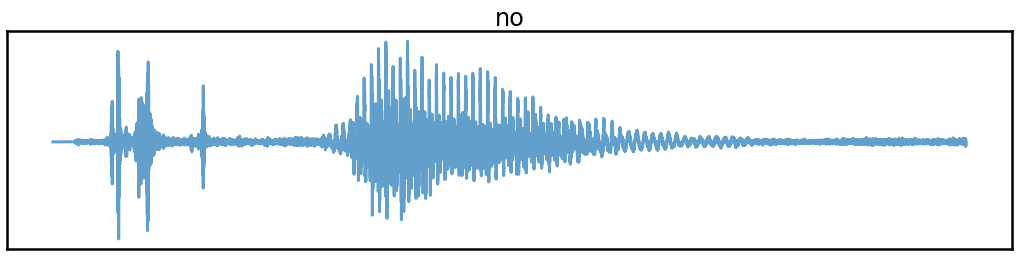

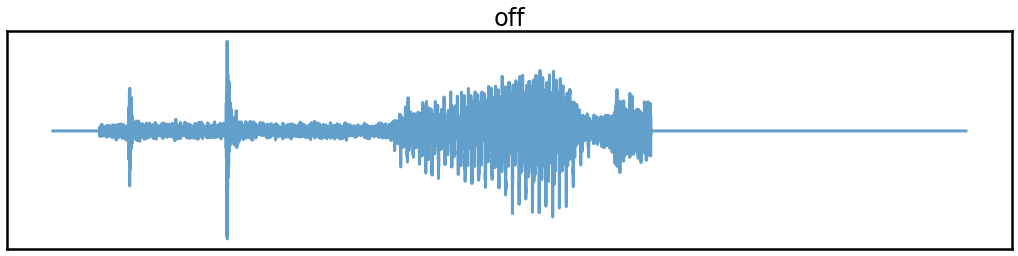

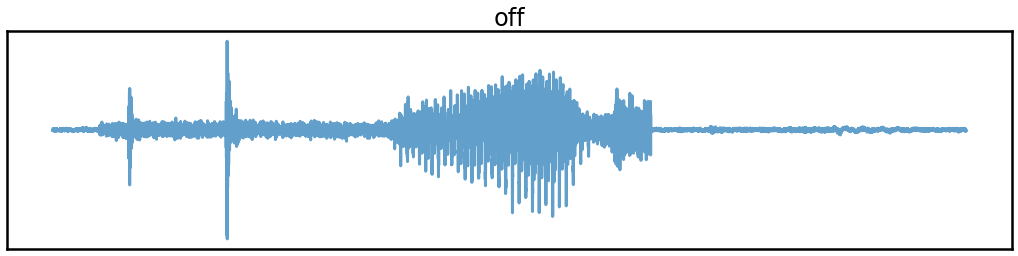

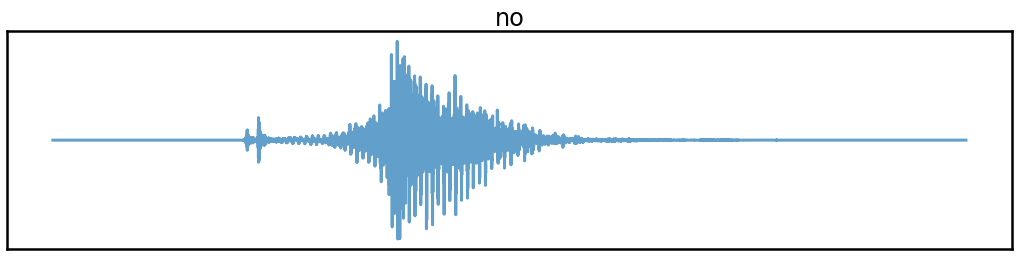

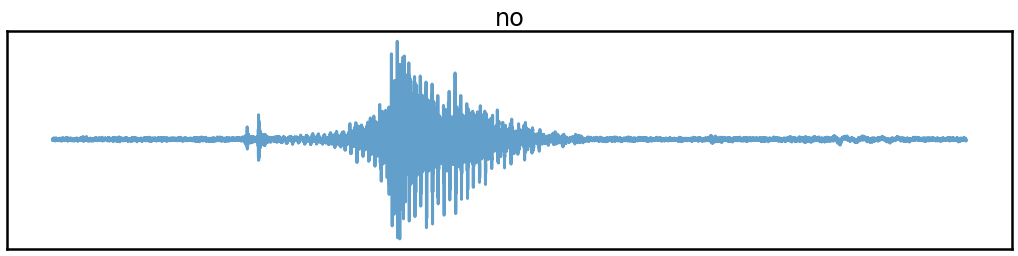

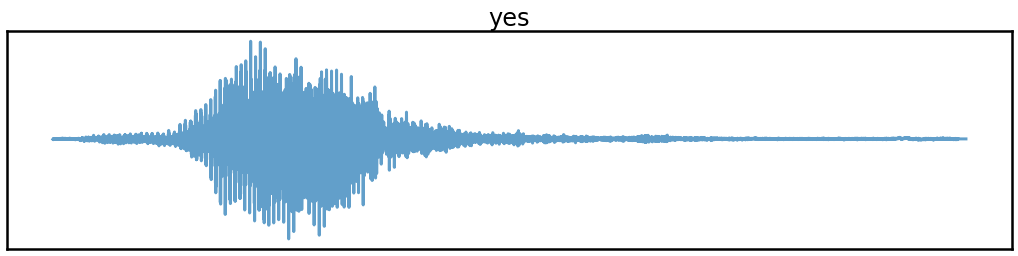

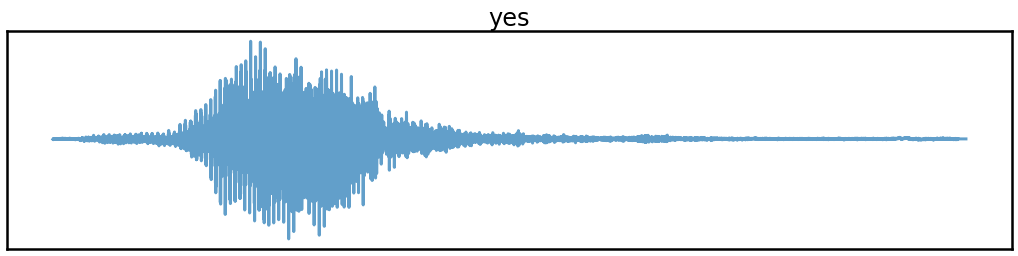

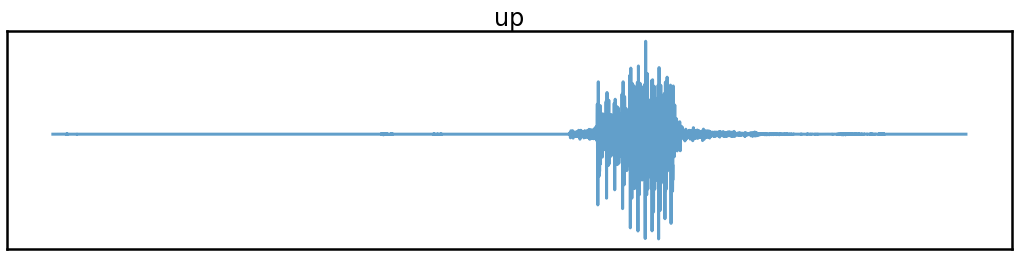

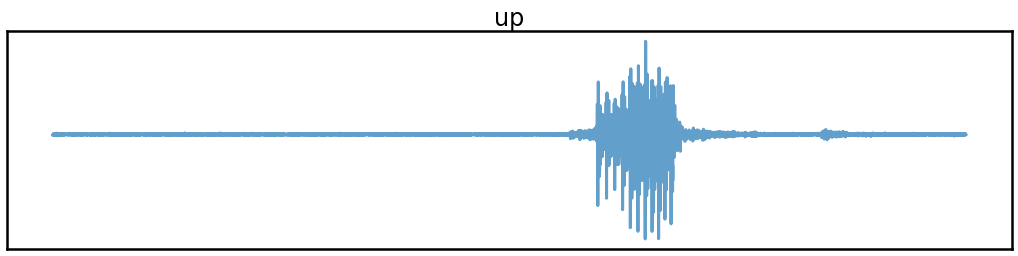

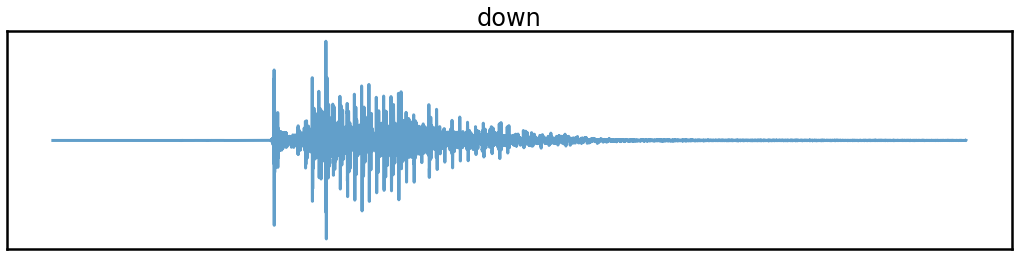

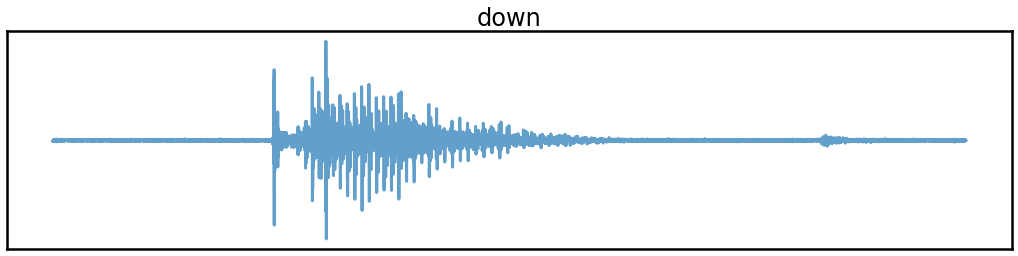

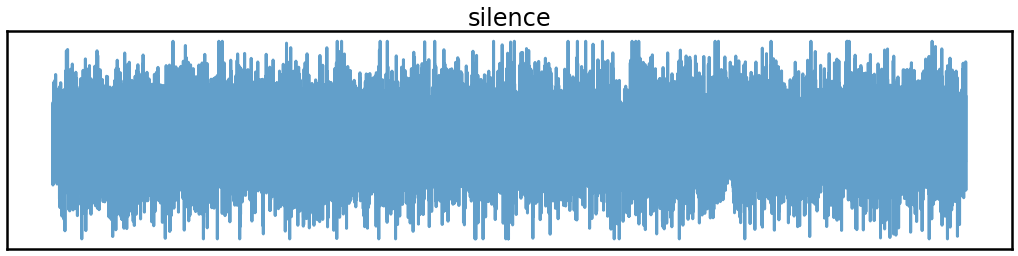

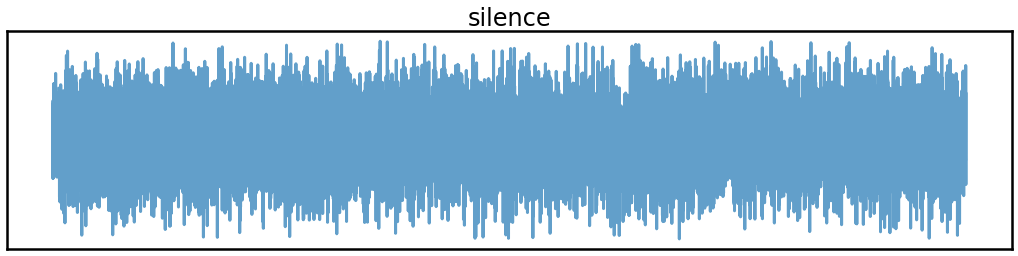

In [45]:
aug_ws = aug_layer(ws, training=True)
sns.set_context("poster")

# plt.figure(figsize=(20,40))

for i in range(10):
    plt.figure(figsize=(18,4))
    
    plt.plot(ws[i], alpha=0.7)
    plt.title(output_classes[labs[i]])
    plt.tick_params(left = False, right = False , labelleft = False ,
            labelbottom = False, bottom = False)
    plt.show()
    plt.figure(figsize=(18,4))
    plt.plot(aug_ws[i], alpha=0.7)
    plt.title(output_classes[labs[i]])
    
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    plt.show()

#     display.display(display.Audio(aug_ws[i],rate=16000))
# plt.savefig("waves.png", dpi=300)


## MFCCS and Spec Augment

In [28]:
from custom_layers import *
ws = []
labs=[]
for i in train_dataset.take(10):
    ws.append(i[0])
    labs.append(i[1])
ws = tf.concat(ws, axis=0)
labs = tf.concat(labs, axis=0)

2021-08-27 18:44:14.663209: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [29]:
mfcc_layer = MFCC()
spec_aug = SpecAugment()
aug_layer = RandomNoiseAugment()

In [30]:
ws

<tf.Tensor: shape=(10, 16000), dtype=float32, numpy=
array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         4.4289879e-03,  2.6712529e-03,  3.6918733e-03],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         5.8681046e-04, -1.0500307e-03, -1.1677810e-05],
       [ 3.2604448e-06, -1.0542115e-04,  1.0868160e-04, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         8.5575972e-05,  8.8543900e-05, -2.5474917e-04],
       [-1.2830310e-02,  1.3406862e-03, -1.4171002e-03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -6.8732770e-04, -7.0794753e-04, -1.4158951e-03]], dtype=float32)>

In [31]:
sns.set_context("poster")
aug_ws = aug_layer(ws, training=True)
X0a = LogMelSpectrogram()(aug_ws)
X0 = LogMelSpectrogram()(ws)
X1 = MFCC(lift_constant=40)(aug_ws)
X02 = spec_aug(X0, training=True)
X2 = spec_aug(X1, training=True)

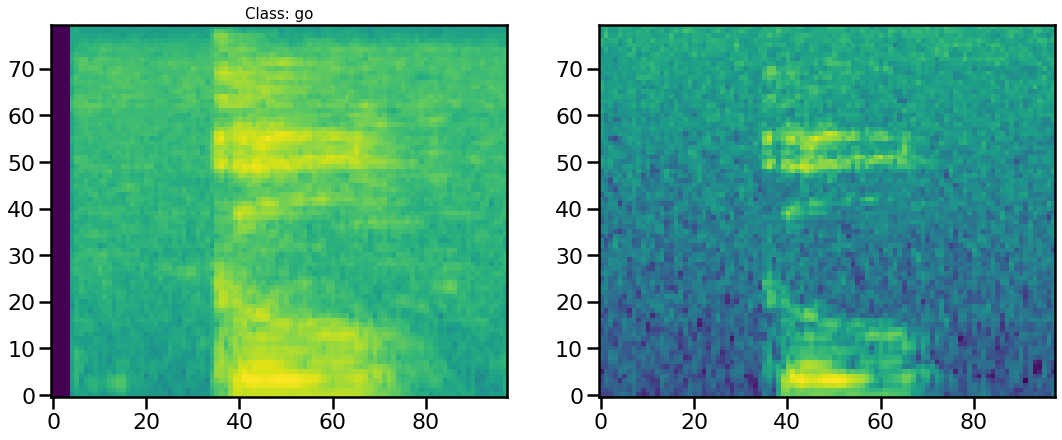

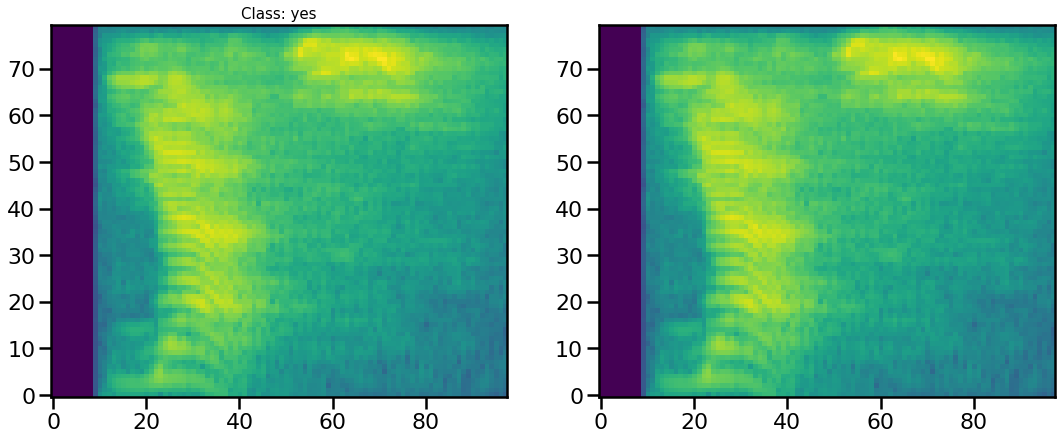

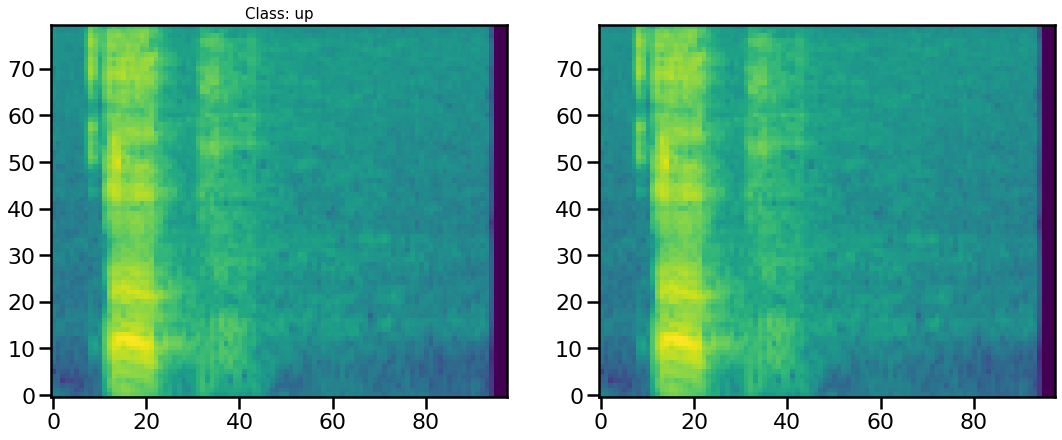

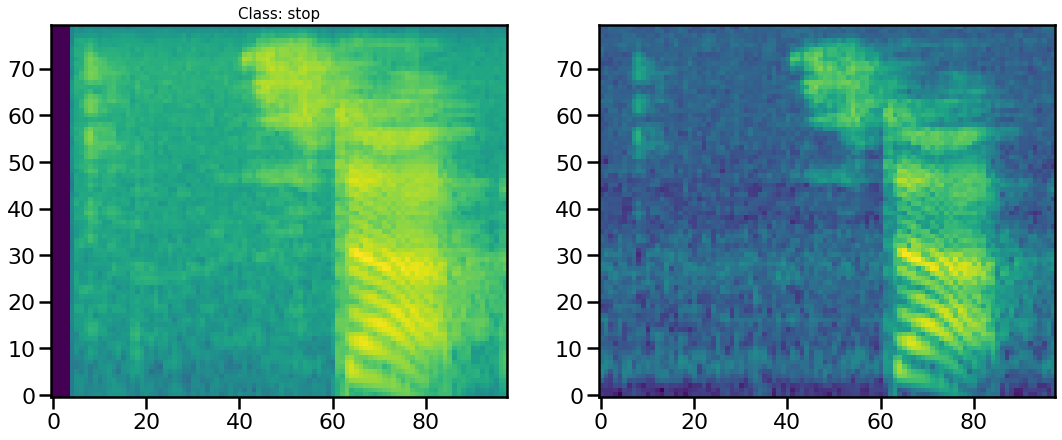

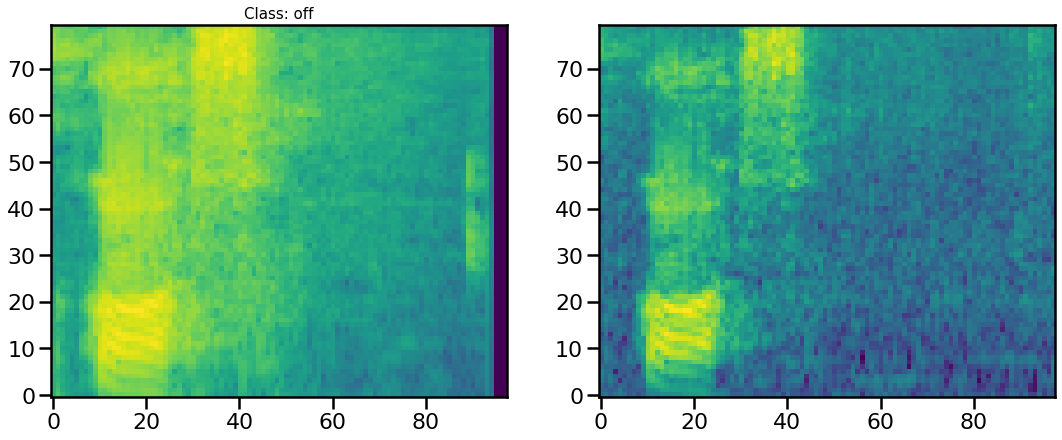

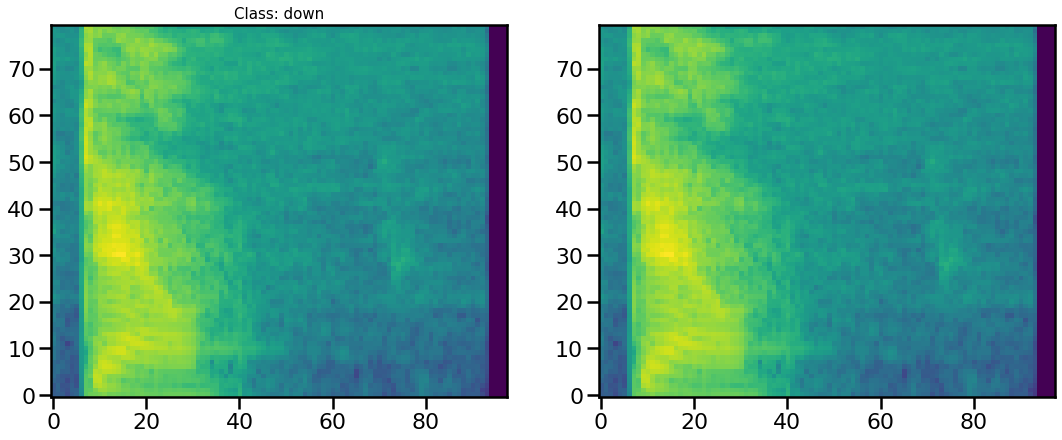

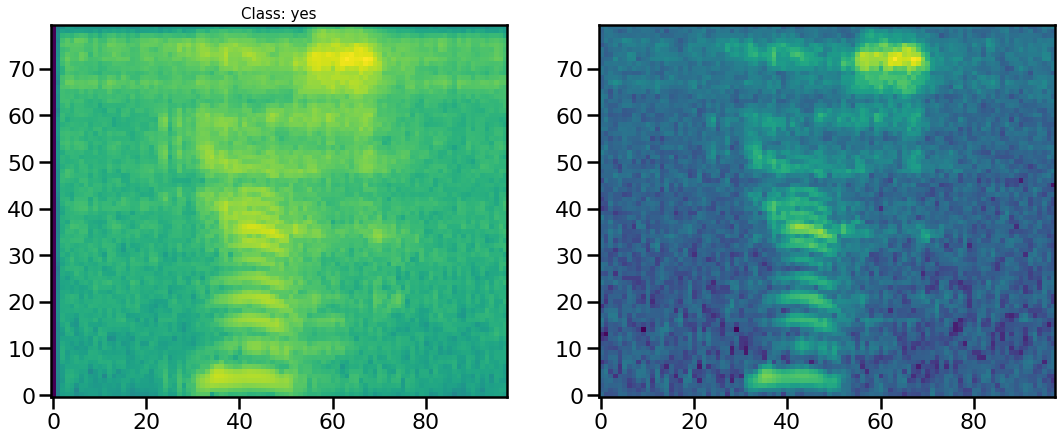

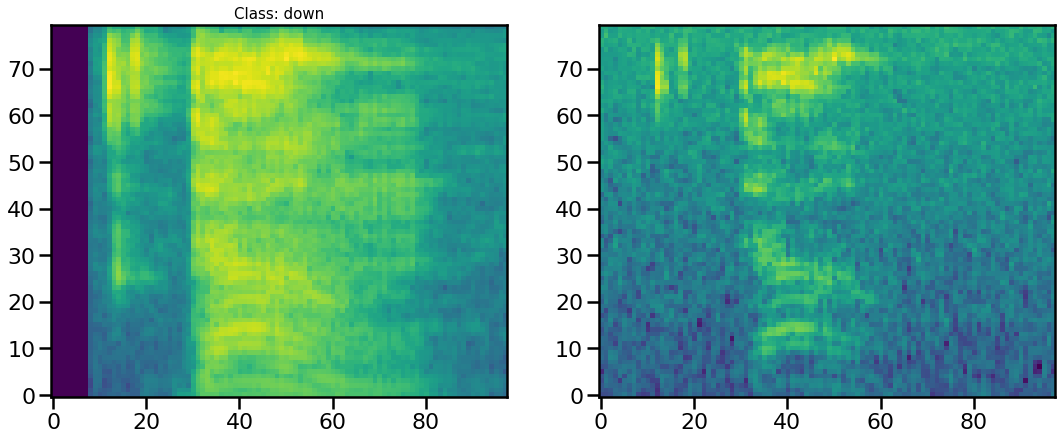

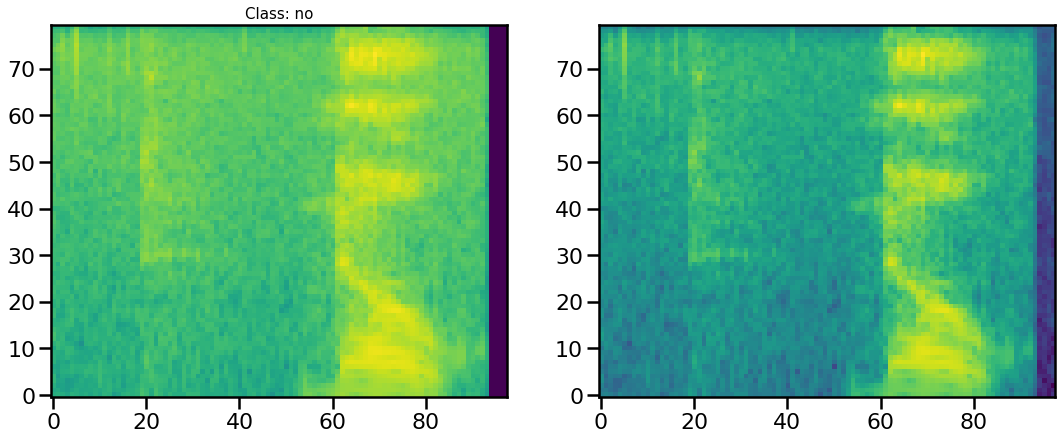

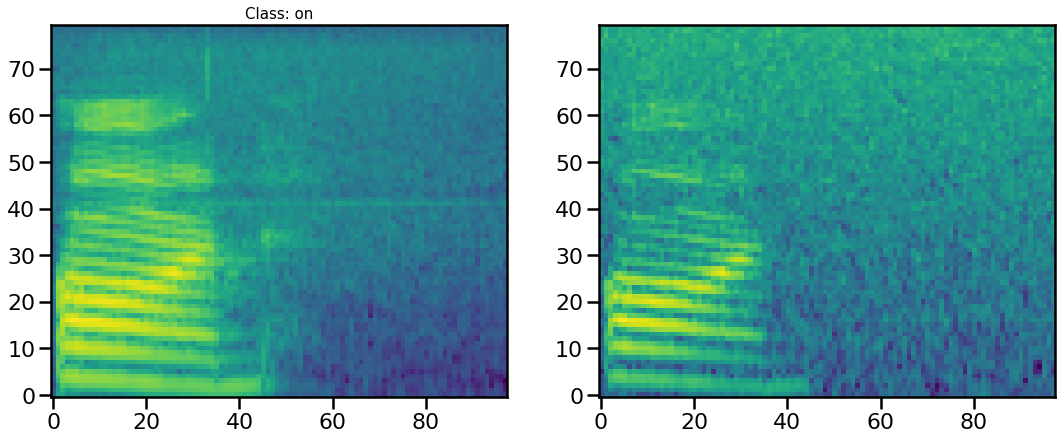

In [32]:
for i in range(10):
    plt.figure(figsize=(18,12))
    plt.subplot(1,2,1)
    plt.imshow(X0[i,:,1:,0].numpy().T, origin='lower')
    plt.title(f"Class: {output_classes[y_train[i]]}", fontsize=15)
    plt.subplot(1,2,2)
    plt.imshow(X0a[i,:,1:,0].numpy().T, origin='lower')
    plt.show()
    display.display(display.Audio(ws[i], rate=16000))
    display.display(display.Audio(aug_ws[i], rate=16000))

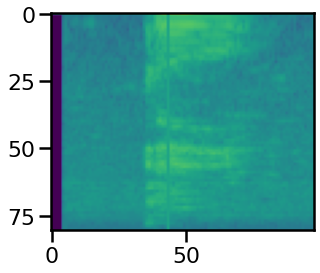

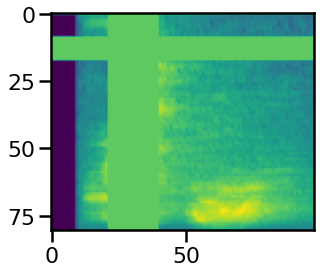

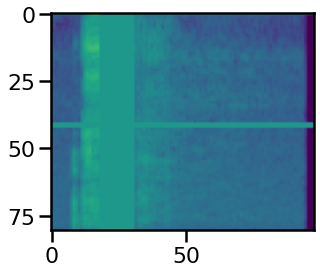

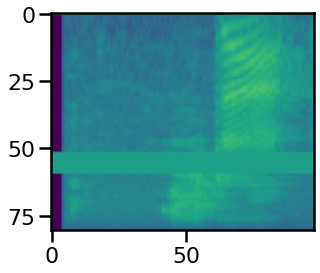

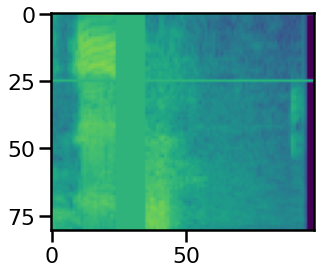

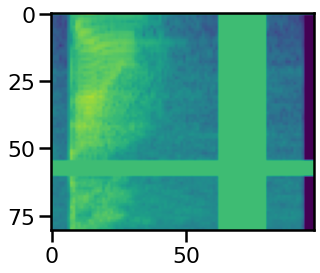

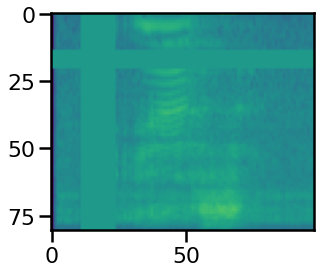

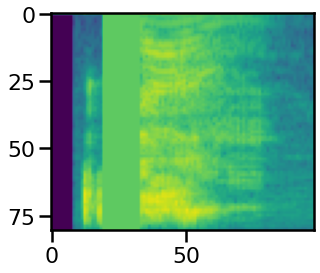

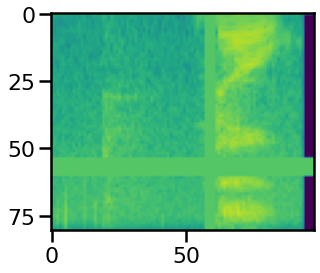

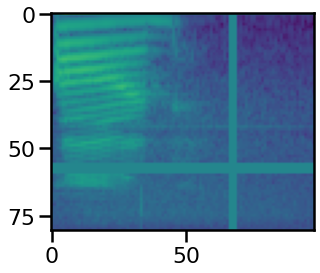

In [33]:
for i in X02:
    plt.imshow(i[:,:,0].numpy().T)
    plt.show()

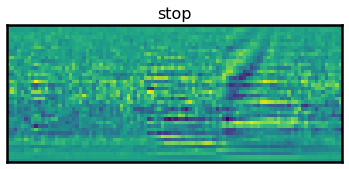

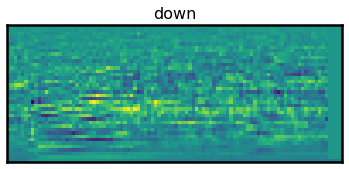

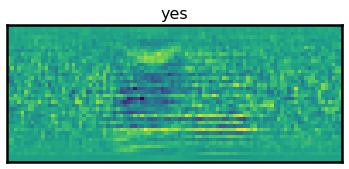

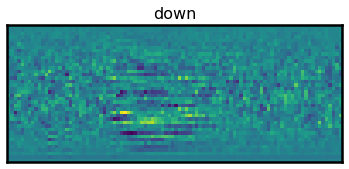

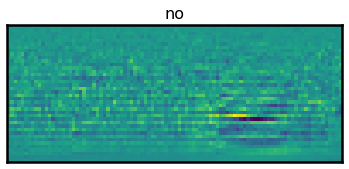

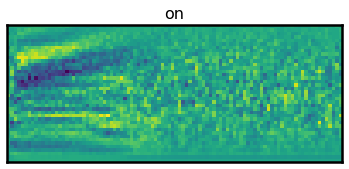

In [34]:
for i in range(10):
    plt.imshow(X1[i,:,:,0].numpy().T, origin='lower')
    plt.title(output_classes[labs[i]], fontsize=16)
    plt.tick_params(left = False, right = False , labelleft = False ,
            labelbottom = False, bottom = False)
    plt.show()

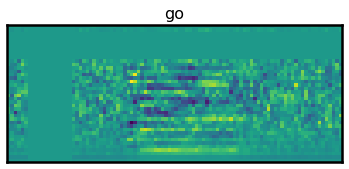

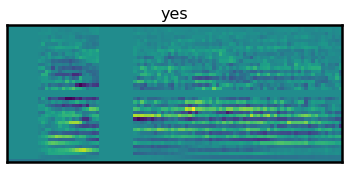

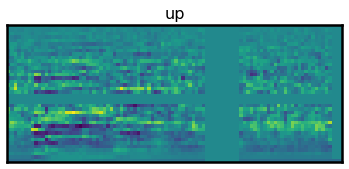

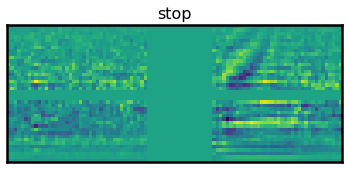

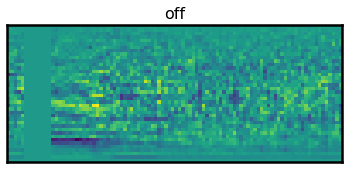

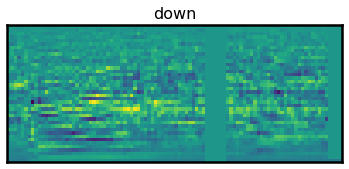

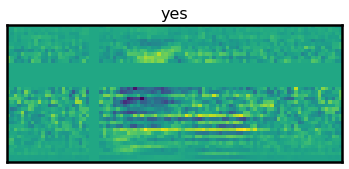

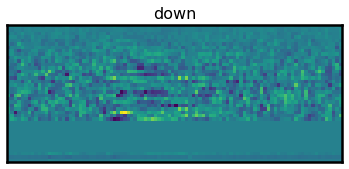

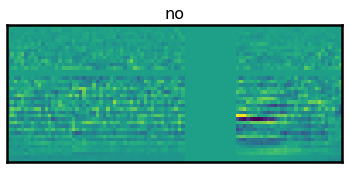

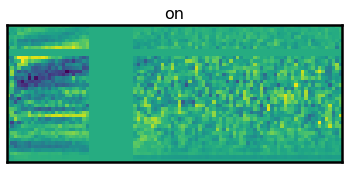

In [35]:
for i in range(10):
    plt.imshow(X2[i,:,:,0].numpy().T, origin='lower')
    plt.title(output_classes[labs[i]], fontsize=16)
    plt.tick_params(left = False, right = False , labelleft = False ,
            labelbottom = False, bottom = False)
    plt.show()